In [1]:
# ipython-input-2-98efb58b741c
# prompt: Download the Dataset
# using the kaggle path dataset
import kagglehub
# # Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
print("Path to dataset files:", path)
# The dataset used in the project is "Brain MRI Images for Brain Tumor Detection." You can download it from Kaggle or any other source. Place the dataset in a folder named brain_tumor_dataset.
# Organize the Dataset
# The dataset should have the following structure:
# Copy
# brain_tumor_dataset/
# ├── yes/
# │   ├── image1.jpg
# │   ├── image2.jpg
# │   └── ...
# └── no/
#     ├── image1.jpg
#     ├── image2.jpg
#     └── ...

!pip install kaggle

# You need to upload your kaggle.json file to access datasets.
# You can find this file in your kaggle account settings.
# After uploading, run this command
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

!unzip brain-mri-images-for-brain-tumor-detection.zip -d brain_tumor_dataset



100%|██████████| 15.1M/15.1M [00:00<00:00, 117MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 272MB/s]
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/15 no.jpg  
  inflating: brai

In [2]:
# Organize the dataset into the desired structure (yes/no folders).
# The provided dataset may need adjustment depending on its actual folder structure.
import os
import shutil

# Example path to the unzipped dataset (Adjust to your actual path).
dataset_path = 'brain_tumor_dataset/brain_tumor_dataset/'

yes_folder = 'brain_tumor_dataset/yes'
no_folder = 'brain_tumor_dataset/no'

if not (os.path.exists(yes_folder) and len(os.listdir(yes_folder)) > 0 and
        os.path.exists(no_folder) and len(os.listdir(no_folder)) > 0):

    os.makedirs(yes_folder, exist_ok=True)
    os.makedirs(no_folder, exist_ok=True)

    # ... (Your original code for moving files) ...
else:
    print("Dataset folders already organized. Skipping organization.")


import os
import shutil
from sklearn.model_selection import train_test_split



Dataset folders already organized. Skipping organization.


In [3]:
# Define paths
# Corrected IMG_PATH to point directly to the folder with 'yes' and 'no'
IMG_PATH = 'brain_tumor_dataset/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
TRAIN_DIR = 'TRAIN/'  # Define TRAIN_DIR



In [4]:
# Create directories
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, 'YES'), exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, 'NO'), exist_ok=True)
os.makedirs(os.path.join(TEST_DIR, 'YES'), exist_ok=True)
os.makedirs(os.path.join(TEST_DIR, 'NO'), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, 'YES'), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, 'NO'), exist_ok=True)



In [5]:
# Split the data
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.') and os.path.isdir(os.path.join(IMG_PATH, CLASS)):  # Ignore hidden files/folders and non-directory items
        class_path = os.path.join(IMG_PATH, CLASS)

        # List only files within the class folder
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        IMG_NUM = len(files)
        train_num = int(0.7 * IMG_NUM)  # 70% for training
        test_num = int(0.15 * IMG_NUM)  # 15% for testing
        val_num = IMG_NUM - train_num - test_num  # Remaining for validation

        for (n, FILE_NAME) in enumerate(files):
            img = os.path.join(class_path, FILE_NAME)  # Use class_path instead of IMG_PATH
            if n < test_num:
                shutil.copy(img, os.path.join(TEST_DIR, CLASS.upper(), FILE_NAME))
            elif n < test_num + train_num:
                shutil.copy(img, os.path.join(TRAIN_DIR, CLASS.upper(), FILE_NAME))
            else:
                shutil.copy(img, os.path.join(VAL_DIR, CLASS.upper(), FILE_NAME))



In [6]:
# ipython-input-6-98efb58b741c
import cv2
import numpy as np

def crop_imgs(set_name):
    cropped_images = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        cropped_images.append(img[y:y+h, x:x+w])
    return np.array(cropped_images)

def preprocess_imgs(set_name, img_size):
    set_name = [cv2.resize(img, img_size) for img in set_name]
    set_name = np.array(set_name)
    set_name = set_name.astype('float32') / 255.0
    return set_name

# ipython-input-7-98efb58b741c
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ipython-input-10-98efb58b741c
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input # Import preprocess_input

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# You need to define validation_generator before using it in model.fit
# Assuming you have a validation data directory similar to TRAIN_DIR
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


history = model.fit(train_generator, epochs=30, validation_data=validation_generator)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 176 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 145s 27s/step - accuracy: 0.5359 - loss: 14.7319 - val_accuracy: 0.7000 - val_loss: 2.5435
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 156s 27s/step - accuracy: 0.7297 - loss: 4.0825 - val_accuracy: 0.9000 - val_loss: 1.0711
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 151s 26s/step - accuracy: 0.7931 - loss: 4.0333 - val_accuracy: 0.9000 - val_loss: 1.0307
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 135s 23s/step - accuracy: 0.8073 - loss: 2.0563 - val_accuracy: 0.7000 - val_loss: 4.4538
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 158s 26s/step - accuracy: 0.7786 - loss: 2.9141 - val_accuracy: 0.8750 - val_loss: 1.2104
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 140s 24s/step - accuracy: 0.7879 - loss: 2.5705 - val_accuracy: 0.9250 - val_loss: 1.0751
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 139s 23s/step - accuracy: 0.8430 - loss: 1.5015 - val_accuracy: 0.9250 - val_loss: 1.0234
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 134s 23s/step - accuracy: 0.8059 - loss: 2.1248 - val_accuracy: 0.9250 - val_loss

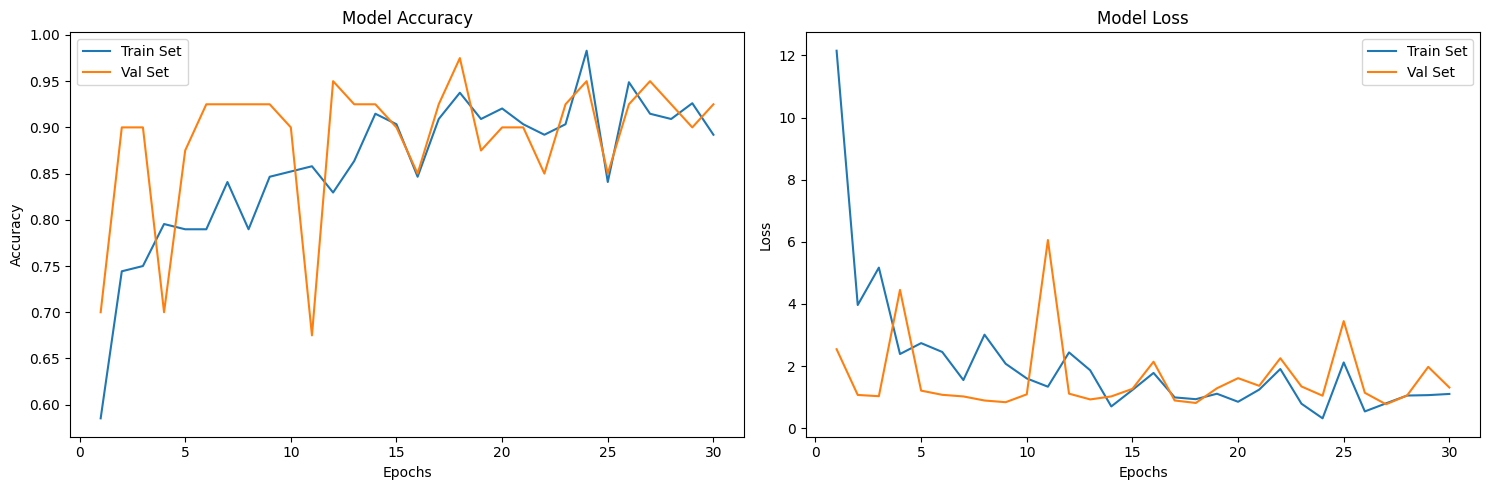

In [7]:
import matplotlib.pyplot as plt # Import the matplotlib library and assign it to the alias 'plt'

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5)) # Now you can use plt.figure() and other matplotlib functions

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Found 40 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
Val Accuracy = 0.91
Confusion matrix, without normalization
[[15  1]
 [ 2 14]]


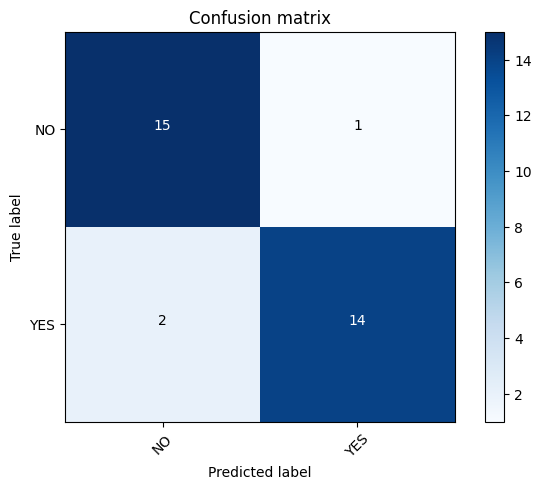

In [8]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools

# ... (previous code) ...

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Preprocess validation data
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size if needed
    class_mode='binary',
    shuffle=False  # Important for consistent predictions
)

# Get X_val_prep and y_val
X_val_prep, y_val = next(validation_generator)

# Continue with predictions
predictions = model.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# ... (rest of the code) ...

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
# Assuming 'labels' is a dictionary mapping class indices to labels
# For example: labels = {0: 'No Tumor', 1: 'Tumor'}
labels = validation_generator.class_indices  # Get labels from the generator
cm = plot_confusion_matrix(confusion_mtx, classes=list(labels.keys()), normalize=False)

Found 37 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step
Test Accuracy = 0.88
Confusion matrix, without normalization
[[12  2]
 [ 2 16]]


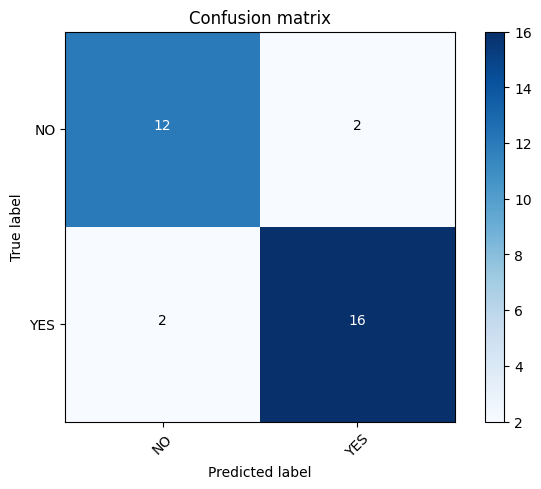

In [9]:
# Preprocess test data similar to validation data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size if needed
    class_mode='binary',
    shuffle=False  # Important for consistent predictions
)

# Get X_test_prep and y_test
X_test_prep, y_test = next(test_generator)

# Now you can make predictions on the test data
predictions = model.predict(X_test_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes=list(labels.keys()), normalize=False)  # Use labels.keys() for class names

In [11]:
import cv2
import numpy as np

def crop_imgs(set_name):
    cropped_images = []
    for img in set_name:
        # Convert the image to 8-bit unsigned integer before converting to grayscale
        img = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        cropped_images.append(img[y:y+h, x:x+w])
    return np.array(cropped_images)

def preprocess_imgs(set_name, img_size):
    set_name = [cv2.resize(img, img_size) for img in set_name]
    set_name = np.array(set_name)
    set_name = set_name.astype('float32') / 255.0
    return set_name

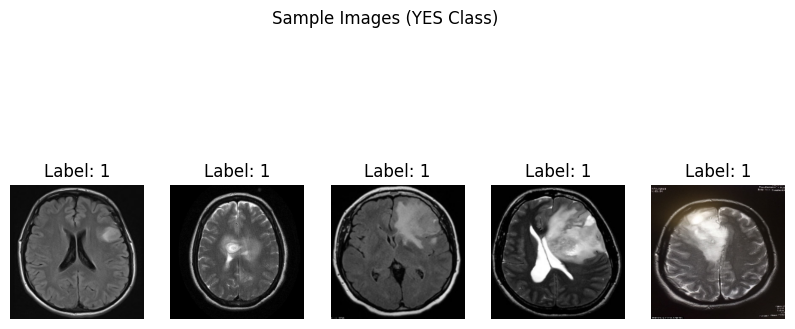

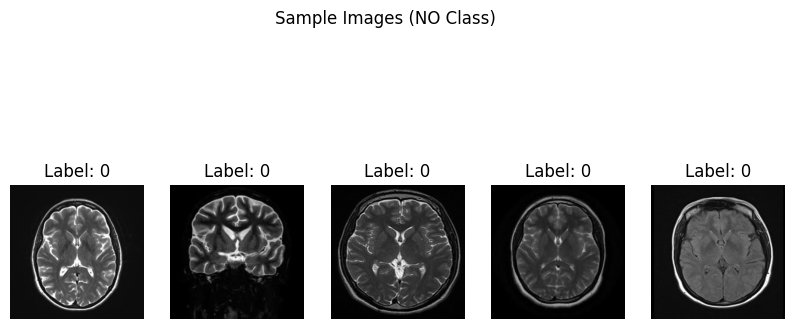

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 127s 25s/step - accuracy: 0.7176 - loss: 0.8362 - val_accuracy: 0.6829 - val_loss: 0.6424
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 126s 21s/step - accuracy: 0.6193 - loss: 0.6501 - val_accuracy: 0.5854 - val_loss: 0.8142
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 141s 21s/step - accuracy: 0.7591 - loss: 0.6620 - val_accuracy: 0.5854 - val_loss: 0.7056
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 141s 24s/step - accuracy: 0.7510 - loss: 0.5410 - val_accuracy: 0.8049 - val_loss: 0.5594
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 126s 21s/step - accuracy: 0.7426 - loss: 0.4900 - val_accuracy: 0.7805 - val_loss: 0.6038
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 125s 25s/step - accuracy: 0.8215 - loss: 0.4323 - val_accuracy: 0.7561 - val_loss: 0.5504
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 125s 21s/step - accuracy: 0.7928 - loss: 0.4699 - val_accuracy: 0.8049 - val_loss: 0.5749
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 125s 21s/step - accuracy: 0.7691 - loss: 0.4729 - val_accuracy: 0.7561 - val_loss:

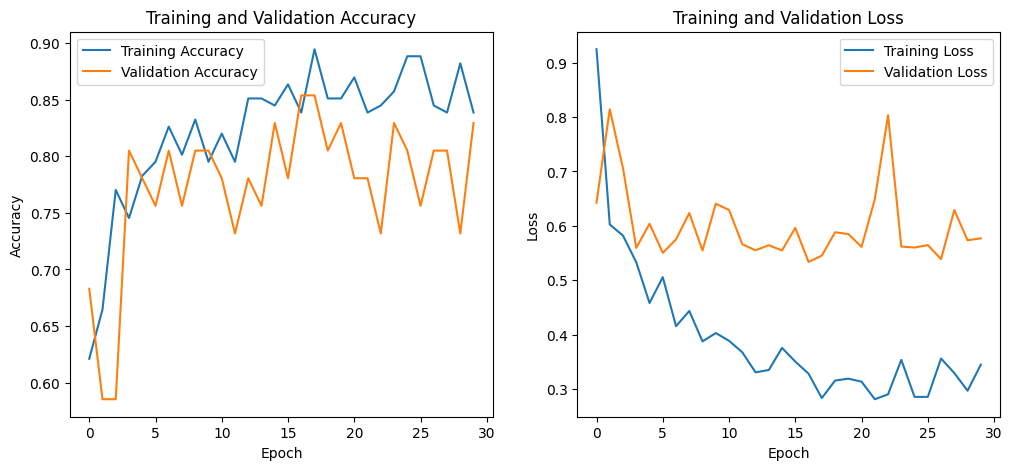

2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 11s/step


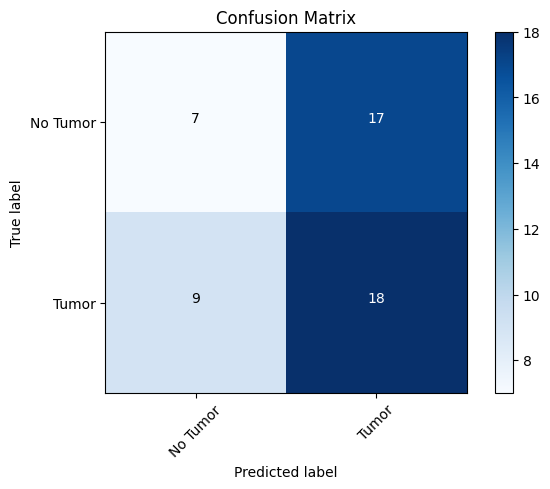

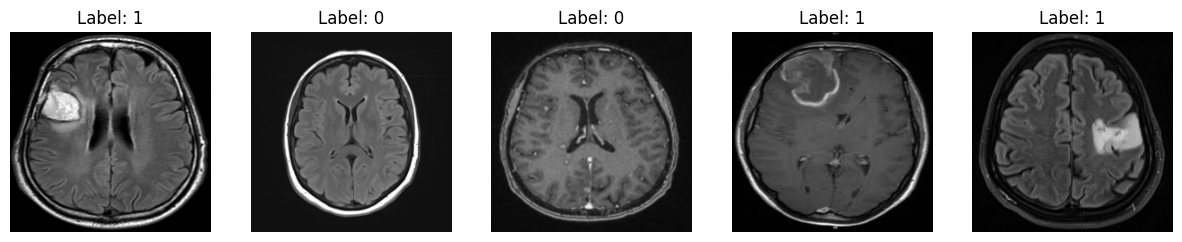

In [16]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

IMG_PATH = 'brain_tumor_dataset/'  # Assuming this is the path to your image data

# Load images and labels into X and y
X = []
y = []

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.') and os.path.isdir(os.path.join(IMG_PATH, CLASS)):
        class_path = os.path.join(IMG_PATH, CLASS)
        for FILE_NAME in os.listdir(class_path):
            if os.path.isfile(os.path.join(class_path, FILE_NAME)):
                img_path = os.path.join(class_path, FILE_NAME)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img = cv2.resize(img, (224, 224))  # Resize images
                X.append(img)
                y.append(1 if CLASS.upper() == 'YES' else 0)  # Assign labels

X = np.array(X)
y = np.array(y)

# Now you can proceed with train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)




# Function to display sample images
def plot_sample_images(images, labels, title):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display sample images from the "YES" class
yes_indices = np.where(y == 1)[0]
plot_sample_images(X[yes_indices[:5]], y[yes_indices[:5]], "Sample Images (YES Class)")

# Display sample images from the "NO" class
no_indices = np.where(y == 0)[0]
plot_sample_images(X[no_indices[:5]], y[no_indices[:5]], "Sample Images (NO Class)")



# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255
)

# Validation and test sets (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Apply augmentation
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=32)
test_generator = val_test_datagen.flow(X_test, y_test, batch_size=32)



# Load pre-trained VGG-16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)  # Now Model is defined

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()



# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)



# Plot accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()



# Predict on the test set
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, classes=['No Tumor', 'Tumor'])
plt.show()



# Save the trained model
model.save('brain_tumor_detection_model.h5')



# Plot sample images with RGB channels
def plot_rgb_images(images, labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

plot_rgb_images(X_train, y_train, num_samples=5)



# Load the model for deployment
from tensorflow.keras.models import load_model
model = load_model('brain_tumor_detection_model.h5')

# Re-compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])